From tutorial at: https://plantcv.readthedocs.io/en/stable/tutorials/morphology_tutorial/

## Input variables
The options class mimics the workflow command-line argument parser that is used for workflow parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later.


In [10]:
# Set the notebook display method
%matplotlib widget

In [11]:
# Import libraries
from plantcv import plantcv as pcv 
from plantcv.parallel import WorkflowInputs
from matplotlib import pyplot as plt
from IPython.display import Image, display
import cv2
import numpy as np

In [12]:
def img_disp(img_to_disp):
    # Display image
    _, img_png = cv2.imencode('.png', cv2.cvtColor(img_to_disp, cv2.COLOR_BGR2RGB))
    display(Image(data=img_png.tobytes(), width=300))

In [13]:
# Input/output options
args = WorkflowInputs(
    images=["./data/root1C.jpeg"],    
    names="image1",
    result="side_view_morphology_analysis.json",
    outdir=".",
    writeimg=True,
    debug="plot"
    )

In [14]:
# Set debug to the global parameter
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 20
pcv.params.text_thickness = 20
pcv.params.line_thickness = 10

## Read the input image

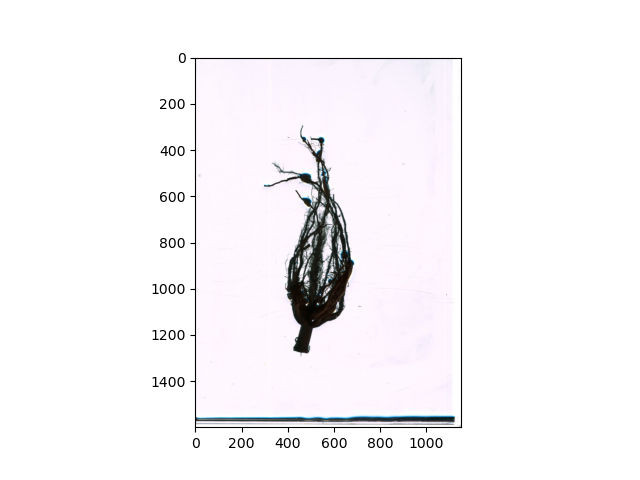

In [15]:
# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image1, mode="native")

# Display image
_, img_png = cv2.imencode('.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#display(Image(data=img_png.tobytes(), width=300))


## Section 2: Isolating plant, making binary mask, getting object(s)
- Requires successful import of image
- See Tools for Thresholding Plant Material for a full list of functions that can be used to create a binary mask
### Visualize colorspaces
The visualization tool converts the color image into HSV and LAB colorspaces and displays the grayscale channels in a matrix so that they can be visualized simultaneously. The idea is to select a channel that maximizes the difference between the plant and the background pixels.

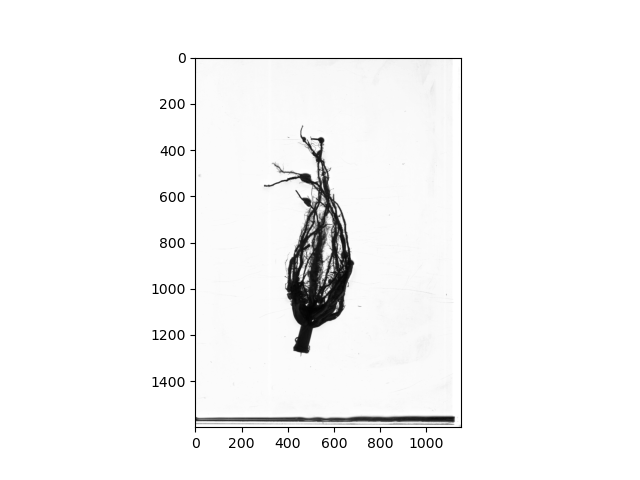

In [16]:
# image converted from RGB to gray.
gray = pcv.rgb2gray(rgb_img=img)

In [17]:
hist = pcv.visualize.histogram(img=gray)

alt.Chart(...)

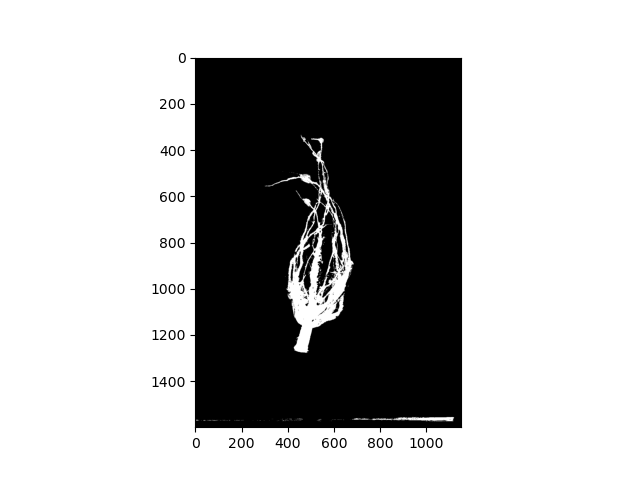

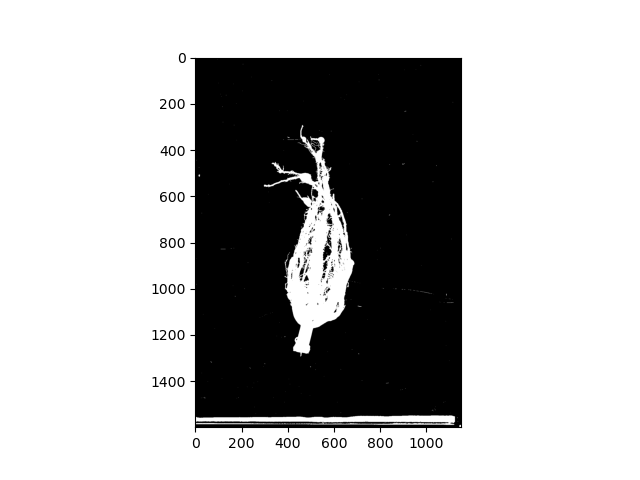

In [18]:
gray_thresh_low = pcv.threshold.binary(gray_img=gray, threshold = 40, object_type='dark')

gray_thresh_high = pcv.threshold.binary(gray_img=gray, threshold = 220, object_type='dark')

## Define region of interest (ROI)

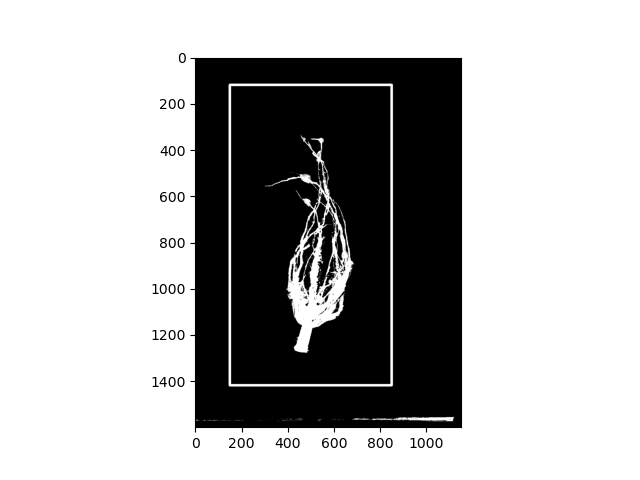

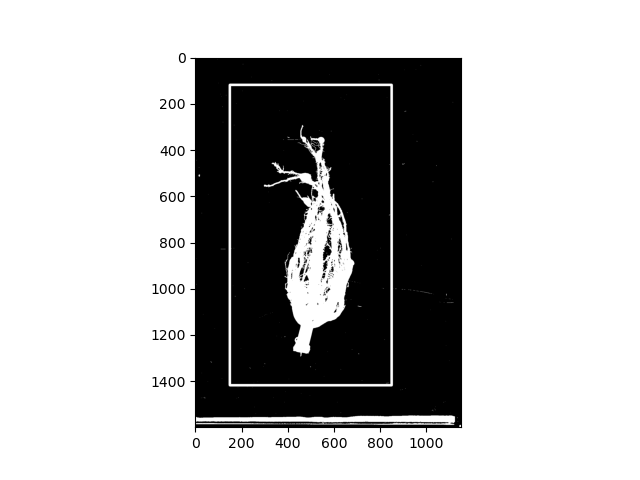

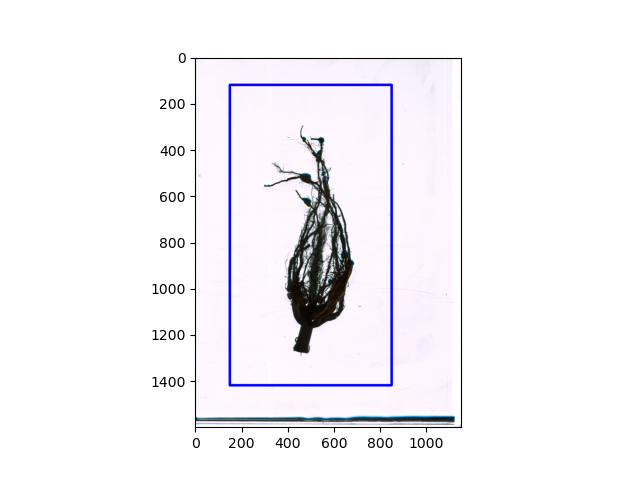

In [19]:
# Crop image
crop_gray_thresh_low = pcv.crop(img=gray_thresh_low, x=150, y=120, h=1300, w=700)

# Crop image
crop_gray_thresh_high = pcv.crop(img=gray_thresh_high, x=150, y=120, h=1300, w=700)

crop_img = pcv.crop(img=img, x=150, y=120, h=1300, w=700)


## Remove small background noise

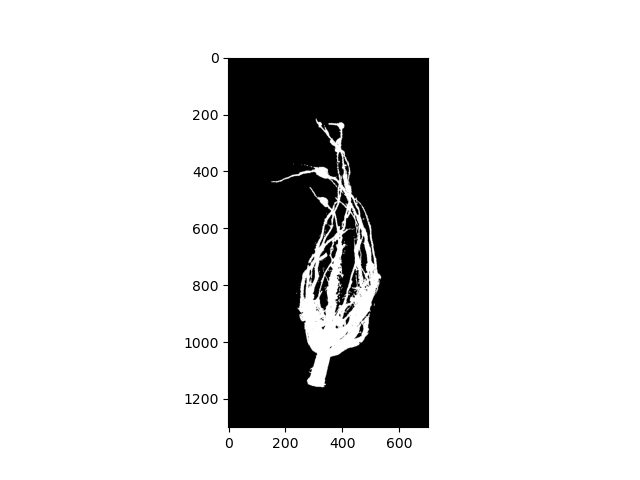

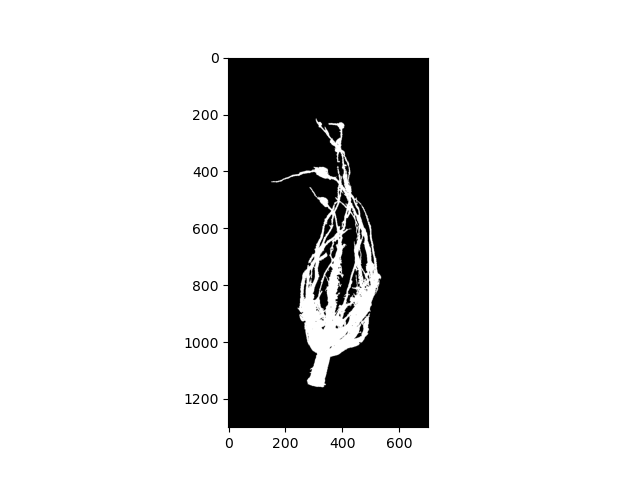

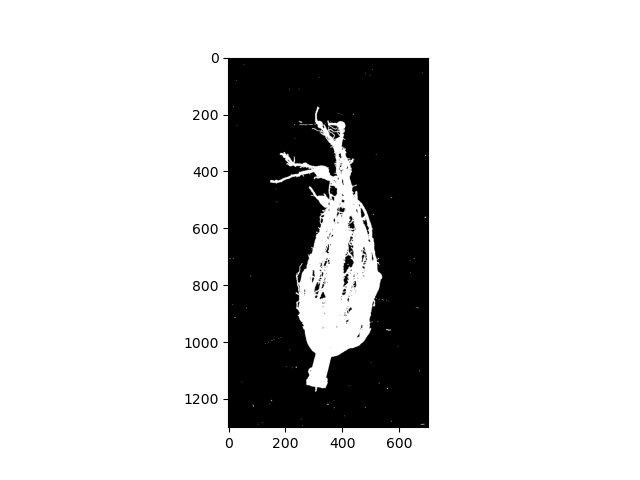

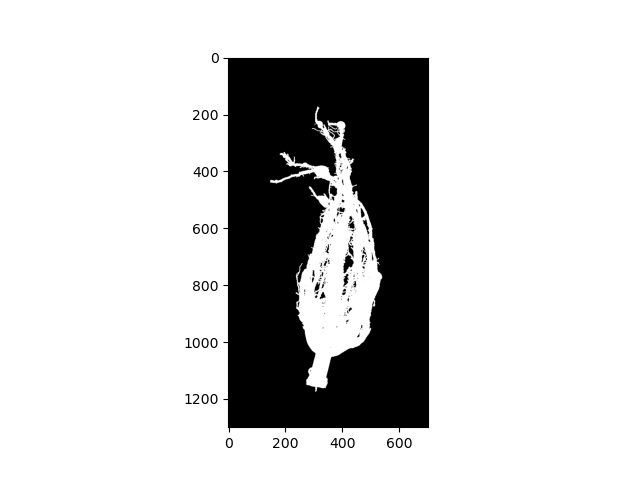

In [20]:
mask_dilated = pcv.dilate(gray_img=crop_gray_thresh_low, ksize=2, i=1)
mask_fill_low = pcv.fill(bin_img=mask_dilated, size=100)

mask_dilated = pcv.dilate(gray_img=crop_gray_thresh_high, ksize=2, i=1)
mask_fill_high = pcv.fill(bin_img=mask_dilated, size=100)


## Morphology analysis

### Skeletonize the mask
Convert the mask into a 1-pixel wide skeleton, which can be used for mophology analyses.

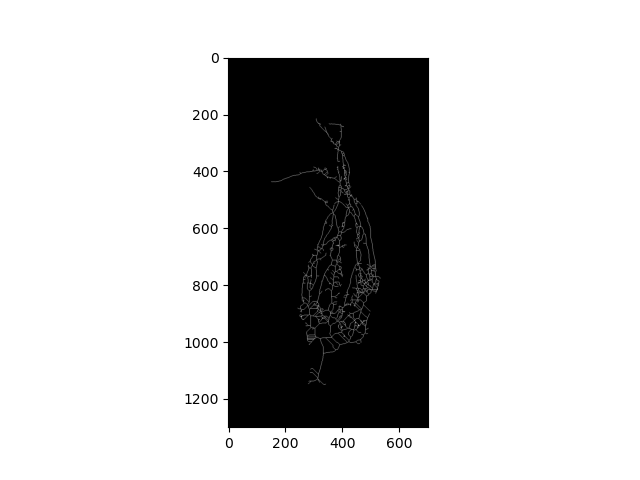

In [25]:
skeleton_low = pcv.morphology.skeletonize(mask=mask_fill_low)
# Display image
_, img_png = cv2.imencode('.png', cv2.cvtColor(skeleton_low, cv2.COLOR_BGR2RGB))

### Prune the skeleton
Generall, skeletonized images will have barbs that represent the width of plant material, which then need to be pruned off.

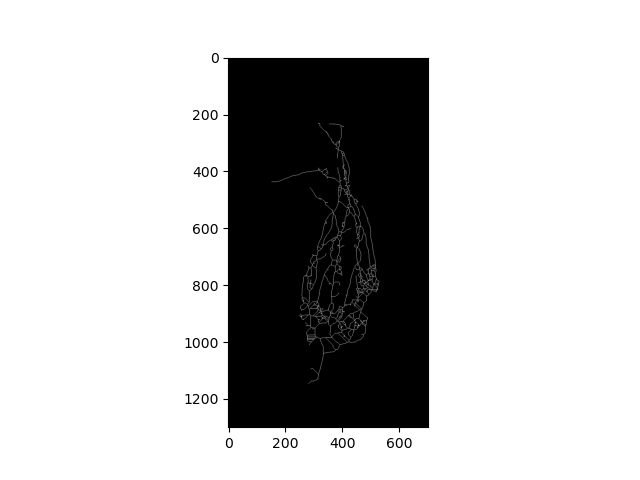

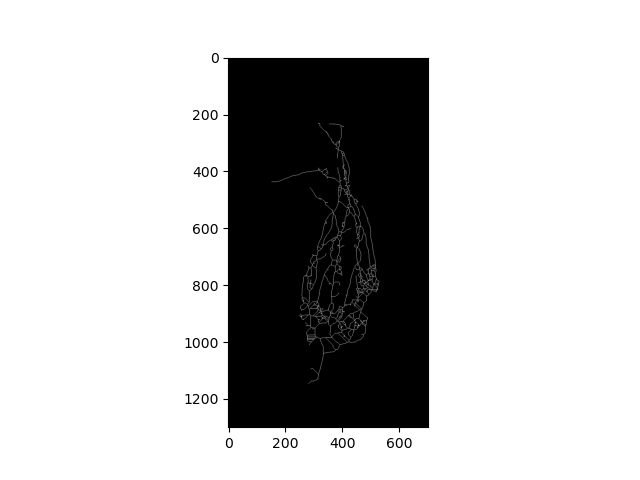

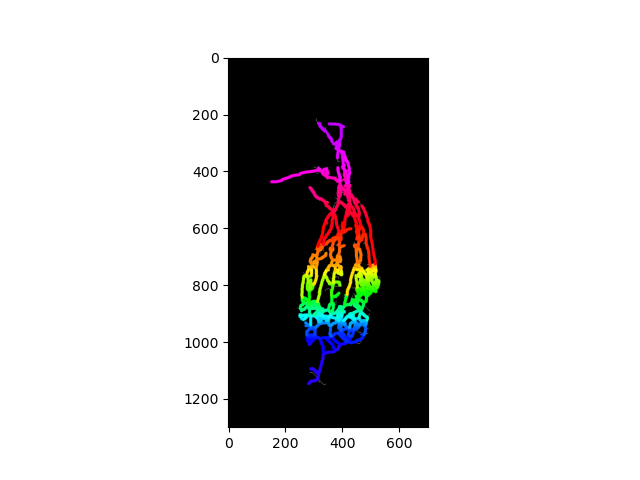

In [22]:
pruned_skel, seg_img, edge_objects = pcv.morphology.prune(skel_img=skeleton_low, size=50, mask=skeleton_low)

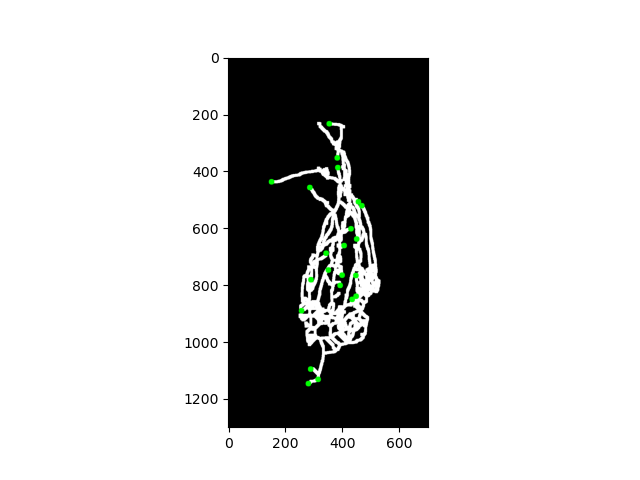

In [23]:
tip_pts_mask = pcv.morphology.find_tips(skel_img=pruned_skel, mask=None, label="default")


In [24]:
# Stain and overlay images
# h, w = tips_dialated.shape[:2]  # height, width

# tips_green = np.zeros((h,w,3), dtype='uint8') 
# tips_green[:,:,1] = tips_dialated  # cv2 uses `BGR` instead of `RGB`

# # Overlay the binary image on the color image
# overlay = cv2.addWeighted(crop_img, 1, tips_green, 0.5, 0)
# img_disp(overlay)

## Find size
Single and multiple objects: https://www.geeksforgeeks.org/measure-size-of-an-object-using-python-opencv/


Size: 1498.7350000000004


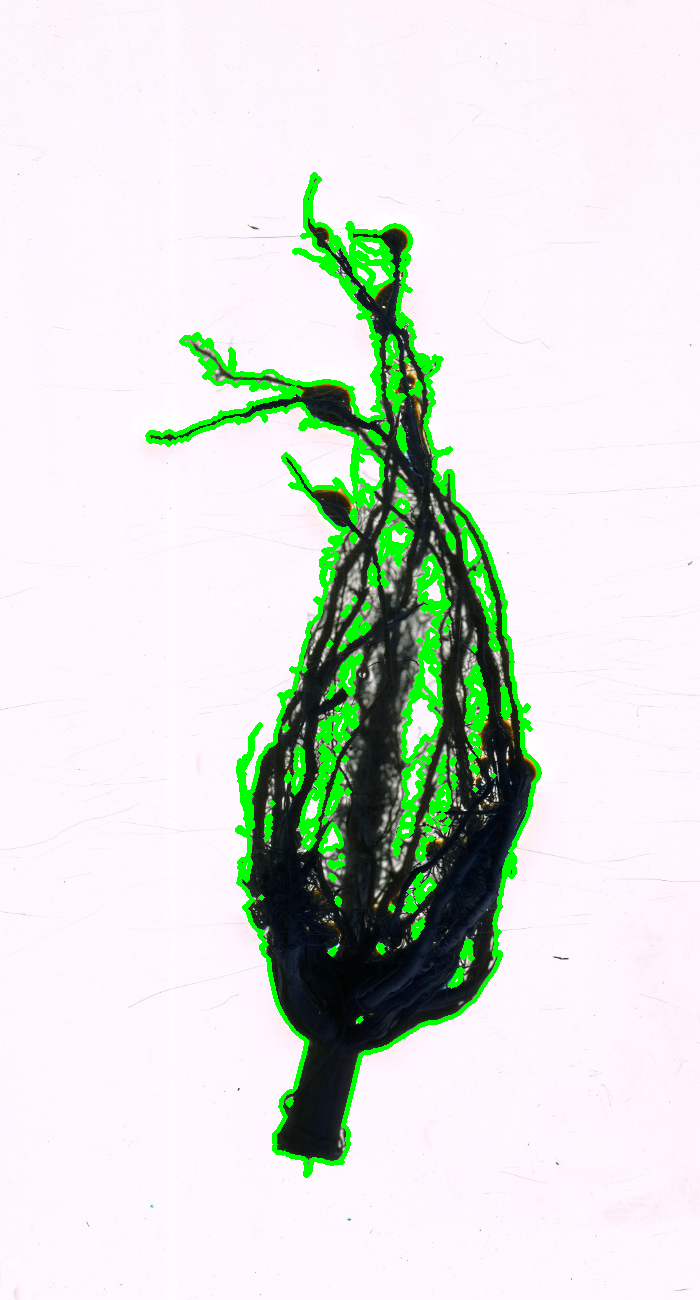

In [26]:
# Find the contours of the object  
contours, hierarchy = cv2.findContours(mask_fill_high, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
  
# Draw the contours on the original image 
cv2.drawContours(crop_img, contours, -1, (0,255,0), 3) 
  
# Get the area of the object in pixels 
area = cv2.contourArea(contours[0]) 

# Convert the area from pixels to a real-world unit of measurement (e.g. cm^2) 
scale_factor = 0.1 # 1 pixel = 0.1 cm 
size = area * scale_factor ** 2
  
# Print the size of the object 
print('Size:', size) 
  
# Display the image with the contours drawn 
img_disp(crop_img)

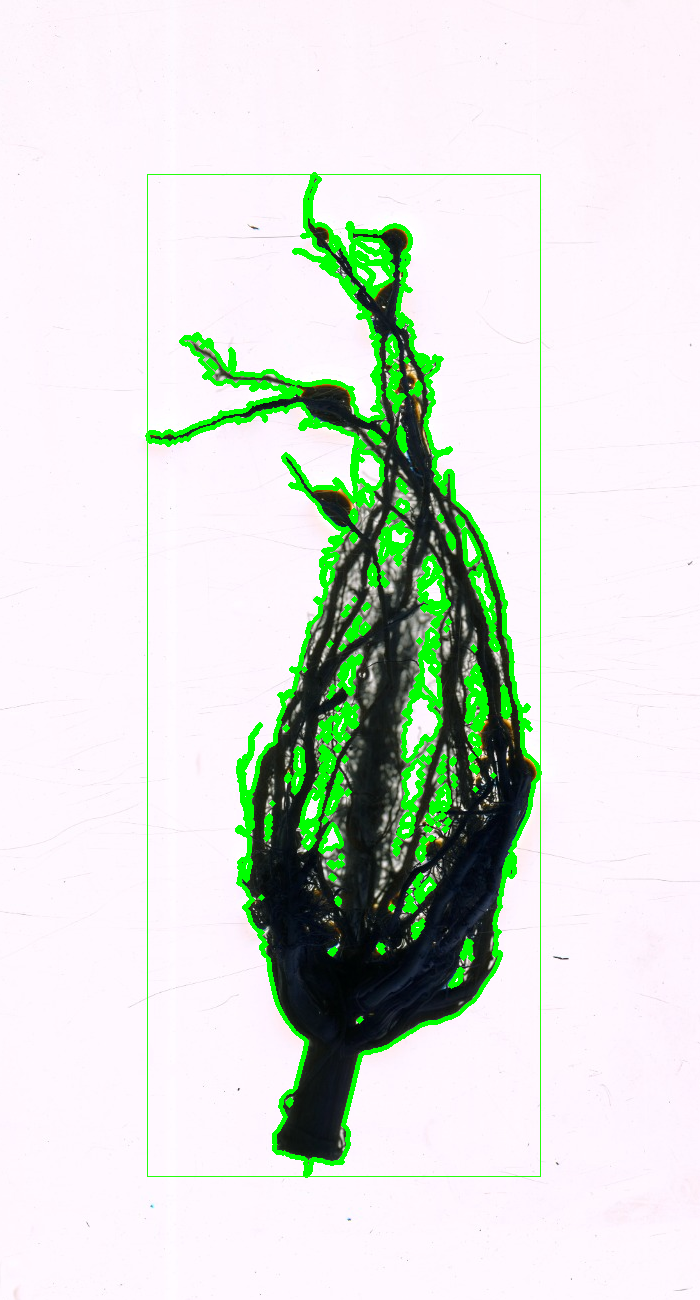

In [29]:
x,y,w,h = cv2.boundingRect(contours[0])
cv2.rectangle(crop_img, (x, y), (x + w, y + h), (36,255,12), 1)
img_disp(crop_img)